# Deutsch-Jozsa Algorithm

## Table of contents
- [Imports and requirements](#imports-and-requirements)
- [Runtime setup](#ibm-quantum-runtime-setup)
- [Step 1: Map](#step-1-map)
- [Step 2: Optimize](#step-2-optimize)
- [Step 3: Execute](#step-3-execute)
- [References](#referances)



## Imports and requirements


To run this notebook it is requiered a python version >= 3.10, personally, I am using python 3.11

In [1]:
from platform import python_version
print(python_version())

3.11.14


In [ ]:
#pip install -r requirements.txt

In [33]:
from dotenv import load_dotenv
import os
import random
import qiskit
from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import SamplerV2 as Sampler, Session
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from collections import Counter

In [4]:
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.3.0


You should have Qiskit version `>=2.0.0`. If you see a lower version, you need to restart your kernel and reinstall the library.

## IBM Quantum Runtime setup
Firstly we will setup the qiskit_ibm_runtime service so we can execute our circuit on a real hardware.
> **Note:**  
> It is highly recommended to check the [official IBM Quantum documentation](https://quantum.ibm.com/docs/).  
>
> In this notebook, we will use the **`.env` method**.  
> Create a `.env` file in the same folder as this notebook and write your **API key** and **CRN** there.  
>
> This approach keeps your credentials secure and out of the public repository.


In [5]:
# Load automatically the .env file from the root of the project 
load_dotenv(override=True)

# Check if the environment variables are set
print("Token (first 6 chars):", os.environ["IBM_QUANTUM_TOKEN"][:6], "...")

# Setup the IBM Quantum Runtime service
service = QiskitRuntimeService(
    channel=os.environ["IBM_QUANTUM_CHANNEL"], 
    token=os.environ["IBM_QUANTUM_TOKEN"], # Your IBM Quantum API key if you are using IBM Quantum Cloud
    instance=os.environ["IBM_QUANTUM_INSTANCE"] # CRN for IBM Quantum Cloud
)
# Check the available backends, if error then your .env is not correctly set
print("Available backends:")
backends = service.backends()
for backend in service.backends():

    print(" -", backend.name)

qiskit_runtime_service._discover_account:WARNING:2026-01-22 22:40:55,269: Loading account with the given token. A saved account will not be used.


Token (first 6 chars): 6vKBpe ...
Available backends:
 - ibm_fez
 - ibm_marrakesh
 - ibm_torino


---

##  Environment Setup Summary

At this point, we have:
- Created a secure **`.env`** file containing our API key and CRN.  
- Configured the connection using **`QiskitRuntimeService`** without saving any credentials locally.  
- Verified that the environment variables are correctly loaded.

Now we are ready to start implementing the **Deutsch–Jozsa algorithm** using Qiskit.  
In the following sections, we will:
1. Review the theoretical foundations of the algorithm.  
2. Build the corresponding quantum circuits step by step.  
3. Test both **constant** and **balanced** functions on simulators and, optionally, on a real quantum backend.

---


# Deutsch-Jozsa-algorithm-implementation

## Introduction
The Deutsch–Jozsa algorithm distinguishes between constant and balanced functions exponentially faster than any classical deterministic algorithm. Even if it is not a usefull algorithm in a practical way, it is a simple example to show the quantum advantage.


## Algorithm description
Deutsch algorithm solves the parity problem for functions such as:

$$
\sum \;\; \longrightarrow \sum
$$
<br>
Deutsch-Jozsa algorithm is the extension of the Deustch algorithm for functions such as:

$$\sum^n \;\;\longrightarrow\;\; \sum \; , \quad n \geq 1 $$

To describe how this algorithm works , imagine this game: Alice, in LA sends a bit string to Bob, who is in NY. Bob calculates the image of some function $ f(x) $ that could work in two different ways. First  $f(x) = 0 \ $  or  $ f(x) = 1 $ , but never both, constant. Otherwise $ f(x) = 0 $ half of the times , $ f(x) = 1 $ the other half, balanced. The goal of Alice is knowing how this $ f(x) $ work, constant or balanced. 

If Bob agrees to use an unitary operator $ U_f $ then, Alice only needs a single query to know how the function $ f(x) $ behaves. On the other hand, the best classical method would require $ 2^{n-1} +1 $  queries.

We will follow the Qiskit workflow pattern: **Map → Optimize → Execute → Post-process**.  
This is the standard workflow used for implementing all quantum algorithms.

## Step 1: Map

Firstly we will setup our qubits. This means $|0\rangle^{\otimes n}$ for Alice and $ |1\rangle $ for Bob's qubit.



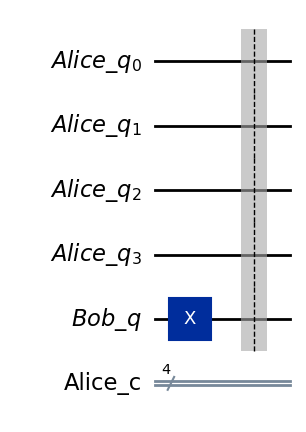

In [6]:
# Define the initial state |ψ0⟩ = |0...01⟩
def psi_0(n:int):
    alice_qr = QuantumRegister(n,name='Alice_q')
    bob_qr = QuantumRegister(1,name= 'Bob_q')
    alice_cr = ClassicalRegister(n,name='Alice_c')
    qc = QuantumCircuit(alice_qr,bob_qr,alice_cr)
    qc.x(n)
    qc.barrier()
    return qc,alice_qr,alice_cr,bob_qr
# For example n = 4, 4 qubits for Alice and 1 for Bob
n = 4
qc,alice_qr,alice_cr,bob_qr = psi_0(n)
qc.draw('mpl')

As you can see. We initialize the circuit in the state $$ |\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle $$ <br> 
To continue we need to create an entangled $|\psi_1\rangle =  H^{\otimes n+1}|\psi_0\rangle $ 
which is $$  H^{\otimes n}|0\rangle  \otimes H|1\rangle$$

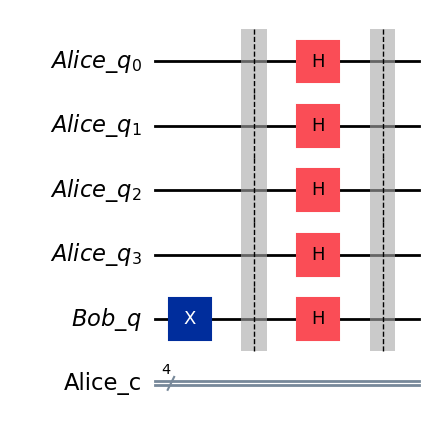

In [7]:
def psi_1(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)->QuantumCircuit:
    qc.h(alice_qr)
    qc.h(bob_qr)
    qc.barrier()
    return qc
qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

We obtain$$ |\psi_1 \rangle = \displaystyle\sum_{x \in \{0,1\}^n}  \frac{|x\rangle}{\sqrt{2^n}} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$ <br>
For example for $ n = 2 $ $$  |\psi_1\rangle = \frac {|00\rangle +|01\rangle + |10\rangle + |11\rangle}{2} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}  $$ <br>


Now the query register is a superposition of all values. Then it is Bob's turn to evaluate $$ U_f : |Alice,Bob\rangle \rightarrow |Alice,Bob \oplus f(x)\rangle$$ <br>

It is important to understand how $ f(x) $ is chosen. Initially before we execute the quantum circuit an oracle chooses between balanced or constant function. For all shots of the execution this decision will be maintained. Now let's recap how $f(x) $ works:
$$
constant \rightarrow f(x) = 
\begin{cases}
0 \ \forall x
\\
1 \ \forall x 

\end{cases}

$$

$$
balanced \ \longrightarrow\
|\{x : f(x)=0\}| = |\{x : f(x)=1\}| = 2^{n-1}
$$

In [8]:
# Define a seed for better reproduction
seed = 23
random.seed(seed)
# Which function we will use for one execution
def choose_const_bal() -> int:
    return random.choice([0, 1, 2])
     
which_fun = choose_const_bal()
print(which_fun)

1


As we have seen, $f(x)$ can output 2 values rather if it is balanced or constant. Let's check how $ U_f $ works:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \big[ U_f|x,0\rangle - U_f|x,1\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,0\oplus f(x)\rangle - |x,1\oplus f(x)\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,f(x)\rangle - |x,1\oplus f(x)\rangle]
$$ 
<br>




Now we will explain how $ U_f $ will change depending on the posible values of  $ f(x) $
$$
f(x) = 0 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,0\rangle - |x,1\rangle \\
f(x) = 1 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,1\rangle - |x,0\rangle  =\frac {1}{\sqrt{2^n}} \big[ -|x,0\rangle-|x,1\rangle\big]

$$
$$ |\psi_2\rangle = \sum_x \frac{(-1)^{f(x)}|x\rangle}{\sqrt{2^n}} \big[ \frac {|0\rangle-|1\rangle }{\sqrt{2}}\big] $$

This phenomena is called phase kickback. This quantum property is one of the most useful  within quantums algorithms. For more detail see: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure

Let's express this phenomena in terms of quantum gates.

In [9]:
#Let's define all the posible functions
def constan0(qc:QuantumCircuit)->QuantumCircuit:
    # We apply the identity
    return qc

def constant1(qc:QuantumCircuit,bob_qr:QuantumRegister)->QuantumCircuit:
    qc.x(bob_qr[0])
    return qc

For the balanced function, we should be more cautious. As we can see $ U_f $ is applied to each $ |x\rangle $. So in the case
$$ 
f(x) = x \longrightarrow  |x\rangle |y\oplus x\rangle \longrightarrow CNOT
$$ 
In the second case:
$$
f(x) =  \neg x \longrightarrow  |x\rangle |y\oplus  \neg x\rangle   ~=~ |x\rangle |y\oplus ( 1 \oplus x\rangle ) =  |x\rangle |(y\oplus  1 )\oplus  x\rangle  \longrightarrow  X \ CNOT
$$

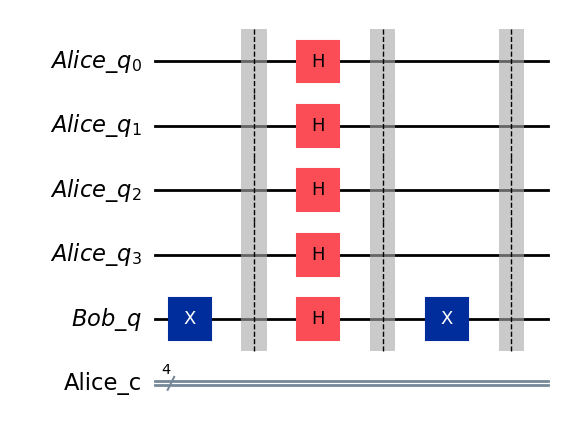

In [10]:
def balanced(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,bob_qr:QuantumRegister,balancer=None)->QuantumCircuit:
    if balancer <=0:
        balancer = random.random()
        print('Balancer was less than 0, new value assigned:', balancer)
    elif balancer >=1:
        balancer = random.random()
        print('Balancer was greater than 1, new value assigned:', balancer)
    if balancer <= 0.5: 
        qc.cx(alice_qr,bob_qr) # N CNOT gates 
        return qc
    else:
        qc.x(bob_qr)
        qc.cx(alice_qr,bob_qr) 
        return qc

def uf(qc:QuantumCircuit,n:int,which_fun:int,alice_qr:QuantumRegister,bob_qr:QuantumRegister,balancer = None)->QuantumCircuit:
    if which_fun == 0:
        qc = constan0(qc)
    elif which_fun == 1:
        qc= constant1(qc,bob_qr)
    else:
        qc = balanced(qc,n,alice_qr,bob_qr,balancer)
    qc.barrier()
    return qc

balancer = random.random()
qc = uf(qc,n,which_fun,alice_qr,bob_qr,balancer)
qc.draw('mpl')

To conclude, we just have to apply a Hadamard gate to Alice's qubits, and measure them.

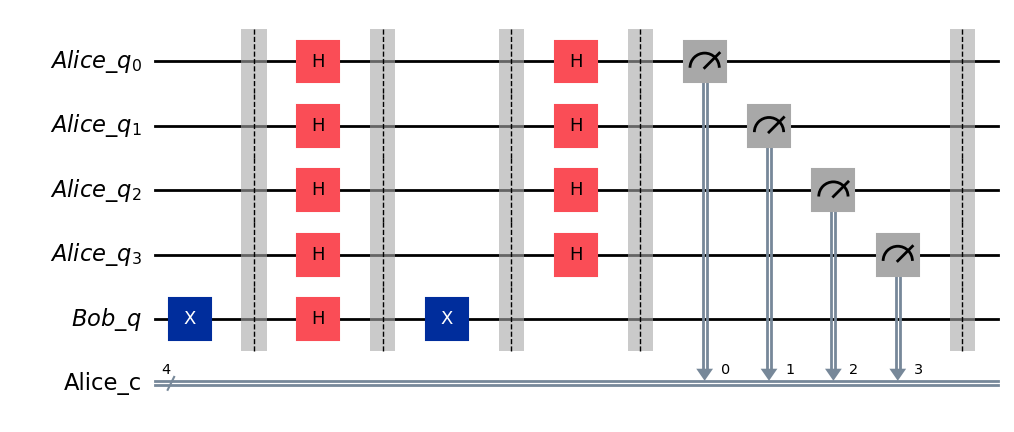

In [11]:
def psi_3(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)-> QuantumCircuit:
    qc.h(alice_qr)
    qc.barrier()
    qc.measure(alice_qr,alice_cr)
    qc.barrier()
    return qc
qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

Finally we obtain:
$$
|\psi_3\rangle = H ^{\otimes n}|x\rangle |y\rangle \longrightarrow
|\psi_3\rangle = \sum_z \sum_x \frac{(-1)^{xz+f(x)}|z\rangle}{2^n} \big[ \frac{|0\rangle-|1\rangle}{\sqrt{2}}\big]
$$
Where $ zx $ is the bitwise inner produnct modulo 2. <br>
At last, is Alice's turn to measure her query registers. The amplitudes should be
$$
f(x) = constant \rightarrow \pm1 \\
f(x) = balanced \rightarrow 0
$$
And we should measure
$$
f(x) = constant \rightarrow 0  \ \forall \ qubits \\
f(x) = balanced \rightarrow \ne 0 \ for \ at \ least \ 1 \ qubit
$$
Now our Quantum Circuit is finally complete. Let's group all of our functions.

In [12]:
def Deutsch_Jozsa_circuit(n:int,which_fun = choose_const_bal,balancer = None)-> dict:
    if balancer is None:
        balancer = random.random()
    qc,alice_qr,alice_cr,bob_qr = psi_0(n)
    qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
    # It's important to clarify that if we do not give any value to 'which_fun' then it will be random
    if which_fun not in [0,1,10]:
        print('Incorrect value for which_fun, a random function will be chosen')
        which_fun = choose_const_bal()
    qc = uf(qc,n,which_fun,alice_qr,bob_qr,balancer)
    qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)

    # Return the circuit, function type, and balancer value
    if which_fun ==0:
        #print('The function is constant 0')
        return {"qc": qc, 'oracle_type':'constant', 'oracle_variant':0}
    elif which_fun ==1:
        #print('The function is constant 1')
        return {"qc": qc, 'oracle_type':'constant', 'oracle_variant':1}

    else:
        #print('The function is balanced')
        if balancer <=0.5:
            #print('Balancer used:', balancer, ' (CNOTs)')
            return {"qc": qc, 'oracle_type':'balanced', 'oracle_variant':'parity'}
        else:
            #print('Balancer used:', balancer, ' (Inverted CNOTs)')
            return {"qc": qc, 'oracle_type':'balanced', 'oracle_variant':'inverted parity'}

Function used: balanced inverted parity


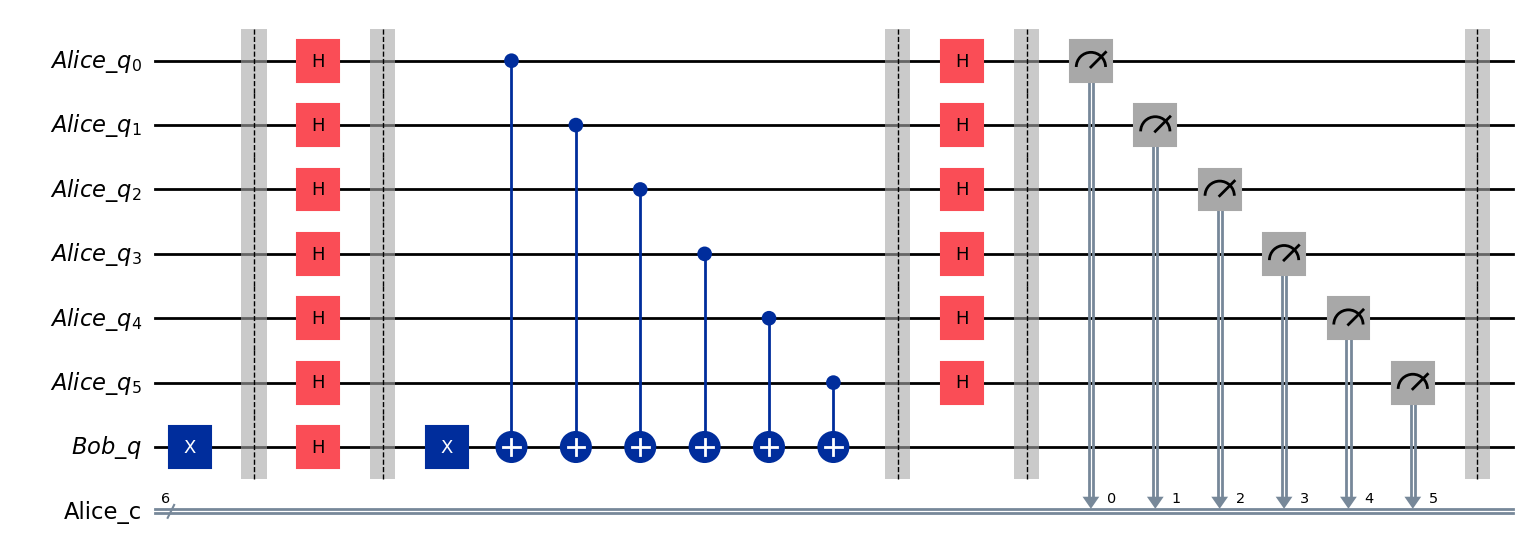

In [13]:
dj_case1= Deutsch_Jozsa_circuit(n = 6, which_fun=10,balancer=0.7)
qc1 = dj_case1["qc"]
print('Function used:',dj_case1['oracle_type'], dj_case1['oracle_variant'])
draw1 = qc1.draw('mpl')
draw1

## Step 2: Optimize 
Following the qiskit workflow. It is turn to optimize our circuit, for decreasing the different types of errors such as: two qubit gates error, really important in the case of $ f(x) = \neg x$, the T2 error, desphasing error, or the readout error because we apply n measurements.


In [14]:
# Select least busy real backend
real_backend = service.least_busy(operational=True, simulator=False)

# Pass managers for real backend (opt level 0 and 3)
pm0 = generate_preset_pass_manager(
    backend=real_backend,
    optimization_level=0,
    seed_transpiler=seed
)

pm3 = generate_preset_pass_manager(
    backend=real_backend,
    optimization_level=3,
    seed_transpiler=seed
)

# ISA circuits for real hardware
real_isa_qc_0 = pm0.run(qc1)
real_isa_qc_3 = pm3.run(qc1)

# Ideal backend
ideal_backend = AerSimulator()

# Ideal circuit 
ideal_pm = generate_preset_pass_manager(
    backend=ideal_backend,
    seed_transpiler=seed
)
ideal_isa_qc = ideal_pm.run(qc1)


We analyze the differences between the depth of an ideal (backend-free) circuit and the same circuit transpiled for a real quantum backend using different optimization levels.

In [15]:
# Original circuit depth
print('Original circuit depth:', qc1.depth())
# For the ideal backend
#Optimized circuit depth level 0
print('Optimized circuit depth level 0:', real_isa_qc_0.depth())
#Optimized circuit depth level 3
print('Optimized circuit depth level 3:', real_isa_qc_3.depth())

Original circuit depth: 11
Optimized circuit depth level 0: 99
Optimized circuit depth level 3: 40


As we can see a higher optimization level leads to  a significant reduction in circuit depth. Now lets execute each circuit to compare if differents levels of optimization translates into better measurements outcomes.


### Step 3: Execute

Now that the circuit has been optimized for the selected backend, we proceed to its execution.  
At small problem sizes, quantum circuits can be efficiently simulated on classical computers. Therefore, we first execute the circuit on an ideal simulator to verify that the Deutsch–Jozsa algorithm is correctly implemented.

> **Note**  
> A sanity check was performed on all four oracle implementations to verify correct Deutsch–Jozsa behavior.


In [16]:
shots = 1024
# Execute on the ideal backend
ideal_job = ideal_backend.run(ideal_isa_qc,shots=shots,seed_simulator=seed)
ideal_result = ideal_job.result()
ideal_counts = ideal_result.get_counts()
print("Ideal backend counts:", ideal_counts)
print('Function used:',dj_case1['oracle_type'], dj_case1['oracle_variant'])



Ideal backend counts: {'111111': 1024}
Function used: balanced inverted parity


The ideal execution yields the expected theoretical outcome, confirming the correct implementation of the Deutsch–Jozsa algorithm.
We now execute the same circuit on a real quantum backend and analyze the resulting behavior.

> **Note**  
> Running on a real quantum device consumes limited QPU time. For this reason, circuits are typically validated on simulators before being executed on real hardware.



In [ ]:

sampler = Sampler(mode = real_backend)
# Execute on the real backend with optimization level 0
# If you want to run the job uncomment the next line
#real_job = sampler.run([real_isa_qc_0, real_isa_qc_3], shots=shots,)
real_result = real_job.result()


The following results correspond to the execution of the circuit on real quantum hardware with optimization level 0.


Name of classical register in qc1: [ClassicalRegister(6, 'Alice_c')]
Most frequent outcome: 111101 (274 shots)


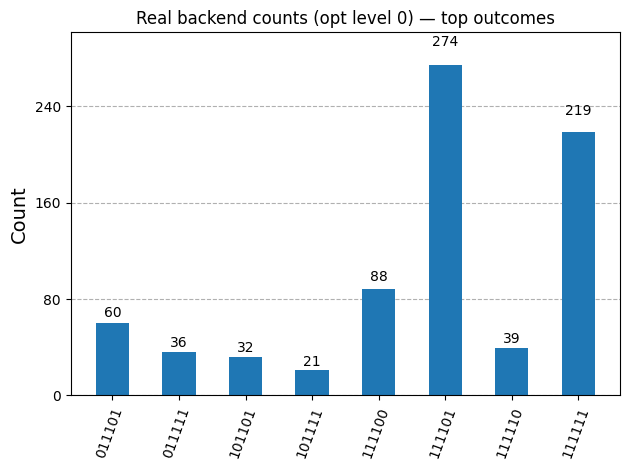

In [ ]:
result_opt0 = real_result[0]
# Since the classical register was renamed to 'Alice_c',
# the measurement results must be accessed using this register name.
print('Name of classical register in qc1:', qc1.cregs)
bitstrings_opt0 = result_opt0.data.Alice_c.get_bitstrings()
# Get counts
counts_opt0 = Counter(bitstrings_opt0)
# Show the results
dominant, freq = counts_opt0.most_common(1)[0]
print(f"Most frequent outcome: {dominant} ({freq} shots)")
# Plot histogram we only for the top 8 outcomes for readability
k = 8
top_counts = dict(counts_opt0.most_common(k))
plot_histogram(top_counts, title="Real backend counts (opt level 0) — top outcomes")


Note that in Qiskit the displayed bitstrings follow little-endian ordering; therefore, a measured string such as `10` corresponds to the state $ |01\rangle $.
\
The following results correspond to the execution of the circuit on real quantum hardware with optimization level 3.




Most frequent outcome: 111111 (681 shots)


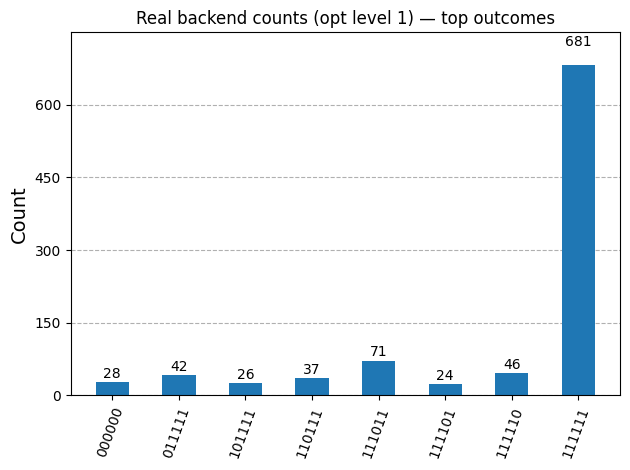

In [ ]:
result_opt3 = real_result[1]

bitstrings_opt3 = result_opt3.data.Alice_c.get_bitstrings()
counts_opt3 = Counter(bitstrings_opt3)
# Show the results
dominant, freq = counts_opt3.most_common(1)[0]
print(f"Most frequent outcome: {dominant} ({freq} shots)")
# Plot histogram we only for the top 8 outcomes for readability
k = 8
top_counts = dict(counts_opt3.most_common(k))
plot_histogram(top_counts, title="Real backend counts (opt level 3) — top outcomes")

### Step 4:

## Referances 
Nielsen & Chuang, sections 1.4.2–1.4.4.
\
ttps://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa
\
qiskit documentation


